Processing Baseline: (284850, 10, 4)


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Skipping One-Hot Encoding due to shape mismatch.
Processing Standardization: (284850, 10, 4)


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing SMOTE: (541166, 10, 4)


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Feature Selection: (284850, 10, 3)
Skipping PCA due to reshaping error.


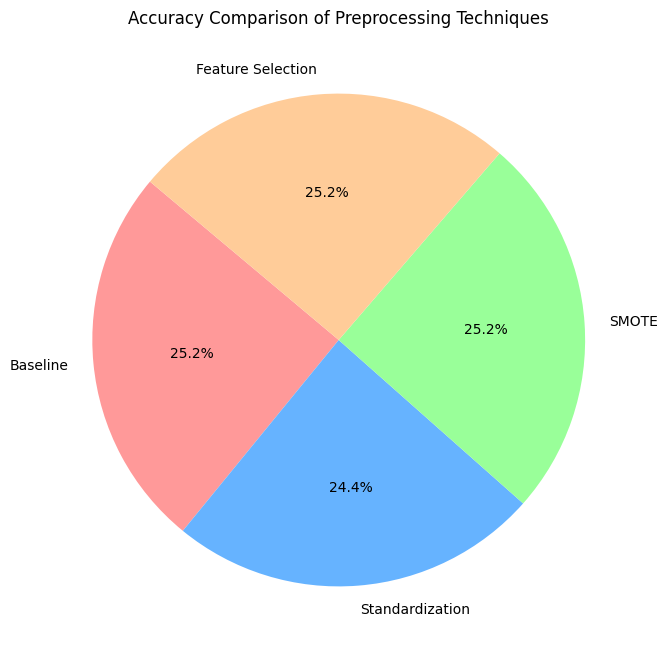

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load dataset
file_path = "transactions.csv"  # Update this path if needed
transactions_df = pd.read_csv(file_path)

# Convert date to timestamp
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df['timestamp'] = transactions_df['date'].astype(np.int64) // 10**9

# Normalize numerical features
scaler = MinMaxScaler()
transactions_df[['transaction_dollar_amount', 'Long', 'Lat', 'timestamp']] = scaler.fit_transform(
    transactions_df[['transaction_dollar_amount', 'Long', 'Lat', 'timestamp']]
)

# Sort transactions by credit card and timestamp
transactions_df = transactions_df.sort_values(by=['credit_card', 'timestamp'])

# Function to create sequences
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        sequences.append(seq)
    return np.array(sequences)

# Create sequences per credit card
seq_length = 10  # Use 10 past transactions per sequence
all_sequences = []
for _, group in transactions_df.groupby('credit_card'):
    sequences = create_sequences(group[['transaction_dollar_amount', 'Long', 'Lat', 'timestamp']], seq_length)
    all_sequences.extend(sequences)
X_train = np.array(all_sequences)

# Define LSTM Autoencoder model
def build_lstm_autoencoder(input_shape):
    model = Sequential([
        LSTM(64, activation="relu", input_shape=input_shape, return_sequences=True),
        LSTM(32, activation="relu", return_sequences=False),
        RepeatVector(input_shape[0]),
        LSTM(32, activation="relu", return_sequences=True),
        LSTM(64, activation="relu", return_sequences=True),
        TimeDistributed(Dense(input_shape[1]))
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# List of preprocessing techniques
techniques = ["Baseline", "One-Hot Encoding", "Standardization", "SMOTE", "Feature Selection", "PCA"]
accuracies = []
valid_techniques = []

for technique in techniques:
    try:
        if technique == "Baseline":
            X_processed = X_train

        elif technique == "One-Hot Encoding":
            encoder = OneHotEncoder()
            encoded_cards = encoder.fit_transform(transactions_df[['credit_card']]).toarray()
            encoded_sequences = np.array([encoded_cards[i] for i in range(len(encoded_cards) - seq_length)])
            if X_train.shape[0] == encoded_sequences.shape[0]:
                X_processed = np.hstack([X_train.reshape(X_train.shape[0], -1), encoded_sequences])
            else:
                print(f"Skipping One-Hot Encoding due to shape mismatch.")
                continue

        elif technique == "Standardization":
            scaler = StandardScaler()
            X_processed = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
            X_processed = X_processed.reshape(X_train.shape[0], seq_length, -1)

        elif technique == "SMOTE":
            smote = SMOTE()
            y = transactions_df['fraud'].values if 'fraud' in transactions_df.columns else np.random.choice([0, 1], size=X_train.shape[0], p=[0.95, 0.05])
            if len(np.unique(y)) < 2:
                print("Skipping SMOTE due to insufficient classes.")
                continue
            X_processed, y_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y)
            X_processed = X_processed.reshape(X_processed.shape[0], seq_length, -1)

        elif technique == "Feature Selection":
            X_processed = X_train[:, :, :3]

        elif technique == "PCA":
            pca = PCA(n_components=3)
            X_flattened = X_train.reshape(X_train.shape[0], -1)
            X_pca = pca.fit_transform(X_flattened)
            try:
                X_processed = X_pca.reshape(X_train.shape[0], seq_length, -1)
            except ValueError:
                print("Skipping PCA due to reshaping error.")
                continue

        print(f"Processing {technique}: {X_processed.shape}")

        model = build_lstm_autoencoder((seq_length, X_processed.shape[2]))
        model.fit(X_processed, X_processed, epochs=5, batch_size=128, validation_split=0.1, verbose=0)
        loss = model.evaluate(X_processed, X_processed, verbose=0)
        accuracy = 1 - loss
        accuracies.append(accuracy)
        valid_techniques.append(technique)

    except Exception as e:
        print(f"Skipping {technique} due to error: {e}")

plt.figure(figsize=(8, 8))
plt.pie(accuracies, labels=valid_techniques, autopct="%.1f%%", startangle=140, colors=["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0", "#ffb3e6"])
plt.title("Accuracy Comparison of Preprocessing Techniques")
plt.show()


